### https://github.com/ChristopherBui3/Metis_Projects/tree/master/Project_5/

### Import Libraries

In [1]:
# !pip3 install opencv-python
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2
import pickle

import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [0]:
# ignore warning messages
warnings.filterwarnings('ignore')

# set the dimensions of the images
width = 128
height= 128
channels= 3

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
cd gdrive/'My Drive'/pkl/

/content/gdrive/My Drive/pkl


In [6]:
ls

X_train.pkl  X_validation.pkl  y_train.pkl  y_validaiton.pkl


In [7]:
pwd

'/content/gdrive/My Drive/pkl'

### The following lines are commented when data prep is done and pickle files are available to load the data.

In [0]:
# train_pathx = 'Data/2 - PSB Crowdsourced Nuclei Annotation/PSB_2015_ImageSize_400/Original_Images/'
# train_pathy = 'Data/2 - PSB Crowdsourced Nuclei Annotation/PSB_2015_ImageSize_400/Nuclei_Segmentation/ContributorsLevel_2_AggregationLevel_3_536562/'

In [0]:
# from glob import glob
# from os.path import expanduser, join, basename
# train_idsx = glob(join(train_pathx, '*.tiff'))
# train_idsy = glob(join(train_pathy, '*.png'))

In [9]:
# x_num = []
# y_num = []
# for i in range(810):
#     a = train_idsx[i].split("/")[-1]
#     x_num.append(a[:len(a)-5])
    
# for i in range(808):
#     b = train_idsy[i].split("/")[-1]
#     y_num.append(b[:len(b)-18])

# for i in x_num:
#     if i not in y_num:
#         print(i)

17200_21400
27700_12200


In [0]:
# train_idsx.remove('Data/2 - PSB Crowdsourced Nuclei Annotation/PSB_2015_ImageSize_400/Original_Images/17200_21400.tiff')
# train_idsx.remove('Data/2 - PSB Crowdsourced Nuclei Annotation/PSB_2015_ImageSize_400/Original_Images/27700_12200.tiff')

In [0]:
# train_idsy.sort()
# train_idsx.sort()

In [12]:
# train_idsx[807]

'Data/2 - PSB Crowdsourced Nuclei Annotation/PSB_2015_ImageSize_400/Original_Images/9700_9800.tiff'

In [13]:
# train_idsy[807]

'Data/2 - PSB Crowdsourced Nuclei Annotation/PSB_2015_ImageSize_400/Nuclei_Segmentation/ContributorsLevel_2_AggregationLevel_3_536562/9700_9800_ConfidenceMap.png'

In [0]:
# def get_data():
#     X_train = np.zeros((len(train_idsx), height, width, channels), dtype=np.uint8)
#     y_train = np.zeros((len(train_idsy), height, width, 1), dtype=np.bool)

#     # get training data
#     for n, train_id in enumerate(train_idsx):

#         img = imread(train_id)[:,:,:channels]
#         img = resize(img, (height, width), preserve_range=True, mode='constant').astype(np.uint8)
#         #img = np.expand_dims(img, axis=0)
#         X_train[n] = img
        
#         mask = imread(train_idsy[n])
#         mask = resize(mask, (height, width), preserve_range=True, mode='constant').astype(np.bool)
#         y_train[n][:,:,0] = mask

#     # create training set & validation set
#     X_valid = X_train[700:]
#     X_train = X_train[:700]

#     y_valid = y_train[700:]
#     y_train = y_train[:700]

#     # pickle the data
#     with open('X_train.pkl','wb') as f:
#         pickle.dump(X_train, f)

#     with open('y_train.pkl','wb') as f:
#         pickle.dump(y_train,f)

#     with open('X_validation.pkl','wb') as f:
#         pickle.dump(X_valid, f)

#     with open('y_validaiton.pkl','wb') as f:
#         pickle.dump(y_valid, f)

# #     with open('X_test.pickle', 'wb') as f:
# #         pickle.dump(X_test, f)

#     return X_train, y_train, X_valid, y_valid

In [0]:
# X_train, y_train, X_validaiton, y_validation = get_data()

In [0]:
X_train = pickle.load(open('X_train.pkl','rb'))
y_train = pickle.load(open('y_train.pkl','rb'))
X_validaiton = pickle.load(open('X_validation.pkl','rb'))
y_validation = pickle.load(open('y_validaiton.pkl','rb'))

In [0]:
# """ --- Tried this function but didn't work ------"""
# @tf.function
# def mean_IOU(y_true, y_pred):
#     m = tf.keras.metrics.MeanIoU(num_classes=2)
#     m.update_state(y_true, y_pred)
#     return(m.result())
# """END OF --- Tried this function but didn't work ------"""

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ =  tf.dtypes.cast(y_pred > t, tf.int32) #tf.to_int32(y_pred > t) #CHANGE MADE HERE
        miou = tf.keras.metrics.MeanIoU(num_classes = 2) #tf.metrics.mean_iou(y_true, y_pred_, 2) #CHANGE MADE HERE
        # K.get_session().run(tf.local_variables_initializer())
        miou.update_state(y_true, y_pred)
        # with tf.control_dependencies():
        #     score = tf.identity(miou.result())
        prec.append(miou.result())
    return K.mean(K.stack(prec), axis=0)




def fit_model(x_train, y_train):
    with tf.device('/gpu:0'):

        inputs = Input((128,128,3))
        norm = Lambda(lambda x: x/255)(inputs)

        conv1 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(norm)
        drop1 = Dropout(0.1)(conv1)
        conv1 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop1)
        pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

        conv2 = Conv2D(128, (3,3), activation = 'elu', kernel_initializer='he_normal', padding='same')(pool1)
        drop2 = Dropout(0.1)(conv2)
        conv2 = Conv2D(128, (3,3), activation = 'elu', kernel_initializer='he_normal', padding='same')(drop2)
        pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

        conv3 = Conv2D(256,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(pool2)
        drop3 = Dropout(0.1)(conv3)
        conv3 = Conv2D(256,(3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop3)
        pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

        conv4 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
        drop4 = Dropout(0.1)(conv4)
        conv4 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop4)
        pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

        conv5 = Conv2D(1024, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
        drop5 = Dropout(0.1)(conv5)
        conv5 = Conv2D(1024, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop5)

        up6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv5)
        up6 = concatenate([up6, conv4])
        conv6 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(up6)
        drop6 = Dropout(0.1)(conv6)
        conv6 = Conv2D(512, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop6)

        up7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv6)
        up7 = concatenate([up7, conv3])
        conv7 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(up7)
        drop7 = Dropout(0.1)(conv7)
        conv7 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop7)

        up8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv7)
        up8 = concatenate([up8, conv2])
        conv8 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(up8)
        drop8 = Dropout(0.1)(conv8)
        conv8 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop8)

        up9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv8)
        up9 = concatenate([up9, conv1])
        conv9 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(up9)
        drop9 = Dropout(0.1)(conv9)
        conv9 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(drop9)

        outputs = Conv2D(1, (1,1), activation='sigmoid')(conv9)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]) #metrics=[mean_iou] #CHANGE MADE HERE
        # model.summary()

        # stop_run = EarlyStopping(patience=3, verbose=1)
        checkpoint_model = ModelCheckpoint('my_unet.h5', monitor='val_mean_io_u_2', mode='max', verbose=1, save_best_only=True)

        results = model.fit(x_train, y_train, validation_split = 0.1, batch_size=16, epochs=100, callbacks=[checkpoint_model])

        model.save('my_unet.h5')

    return model, results

In [0]:
def iou(img1, img2):
    intersection = np.sum(img1 * img2)
    union = np.sum(img1+img2) - intersection

    return intersection / union


def main():

    # instantiate U-NET model & fit to training data
    model_, hist = fit_model(X_train, y_train)

    # predict on validation set
    y_pred = model_.predict(X_validaiton, verbose=1)

    # imshow(y_pred[0])

    with open('y_pred.pickle','wb') as f:
        pickle.dump(y_pred,f)

    # compute Intersection over Union values
    iou_values = []

    for i in range(len(y_validation)):
        iou_ = iou(y_validation[i], y_pred[i])
        iou_values.append(iou_)

    average_iou = np.mean(iou_values)


    print('average_iou: ', average_iou)


    return y_pred, iou_values, average_iou, hist

In [18]:
y_pred, iou_values, average_iou, history = main()

Train on 630 samples, validate on 70 samples
Epoch 1/100
630/630 [==============================] - 15s 24ms/step - loss: 2.7390 - mean_io_u: 0.3699 - val_loss: 0.4389 - val_mean_io_u: 0.3692
Epoch 2/100
630/630 [==============================] - 5s 9ms/step - loss: 0.4100 - mean_io_u: 0.3685 - val_loss: 0.4007 - val_mean_io_u: 0.3678
Epoch 3/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3774 - mean_io_u: 0.3680 - val_loss: 0.3956 - val_mean_io_u: 0.3673
Epoch 4/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3591 - mean_io_u: 0.3669 - val_loss: 0.3143 - val_mean_io_u: 0.3670
Epoch 5/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3365 - mean_io_u: 0.3668 - val_loss: 0.2761 - val_mean_io_u: 0.3669
Epoch 6/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3294 - mean_io_u: 0.3668 - val_loss: 0.3108 - val_mean_io_u: 0.3668
Epoch 7/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3002 -

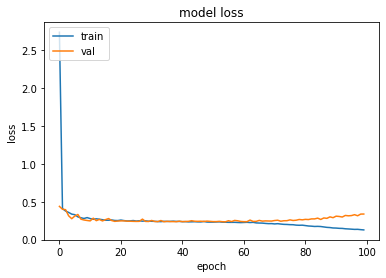

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
average_iou

0.62210035

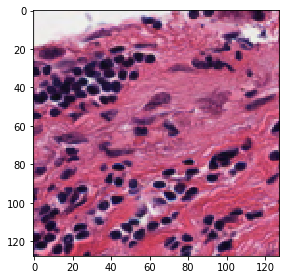

In [21]:
imshow(X_validaiton[0])

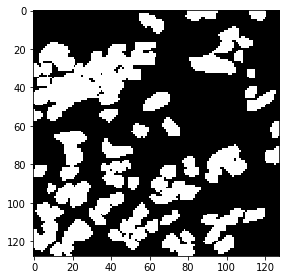

In [22]:
imshow(y_validation[0][:,:,0])

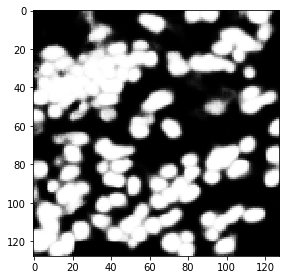

In [23]:
imshow(y_pred[0][:,:,0])

In [24]:
y_pred2, iou_values2, average_iou2, history2 = main()

Train on 630 samples, validate on 70 samples
Epoch 1/100
630/630 [==============================] - 7s 11ms/step - loss: 0.9180 - mean_io_u_1: 0.3717 - val_loss: 0.4597 - val_mean_io_u_1: 0.3679
Epoch 2/100
630/630 [==============================] - 5s 9ms/step - loss: 0.4230 - mean_io_u_1: 0.3678 - val_loss: 0.4378 - val_mean_io_u_1: 0.3670
Epoch 3/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3552 - mean_io_u_1: 0.3667 - val_loss: 0.3169 - val_mean_io_u_1: 0.3668
Epoch 4/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3300 - mean_io_u_1: 0.3668 - val_loss: 0.3673 - val_mean_io_u_1: 0.3666
Epoch 5/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3132 - mean_io_u_1: 0.3668 - val_loss: 0.3075 - val_mean_io_u_1: 0.3665
Epoch 6/100
630/630 [==============================] - 5s 9ms/step - loss: 0.3134 - mean_io_u_1: 0.3663 - val_loss: 0.2694 - val_mean_io_u_1: 0.3665
Epoch 7/100
630/630 [==============================] - 5s 9m

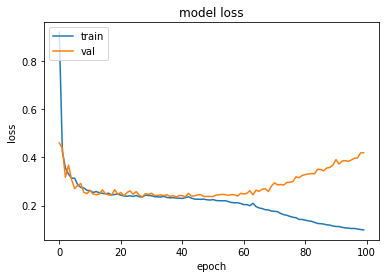

In [25]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

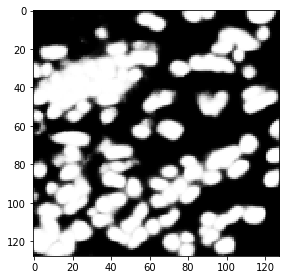

In [26]:
imshow(y_pred2[0][:,:,0])

In [27]:
average_iou2

0.63345027

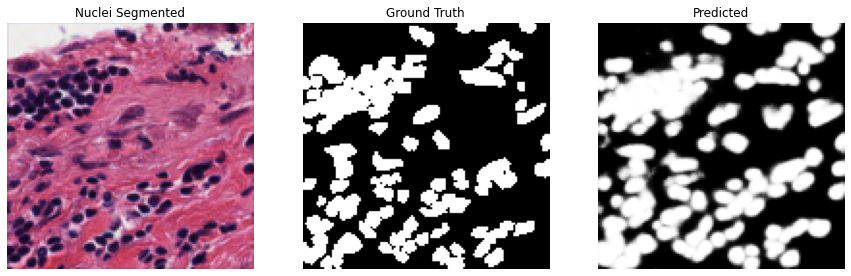

In [33]:
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(X_validaiton[0])
plt.title('Nuclei Segmented')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(y_validation[0][:,:,0])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(y_pred2[0][:,:,0])
plt.title('Predicted')
plt.show()

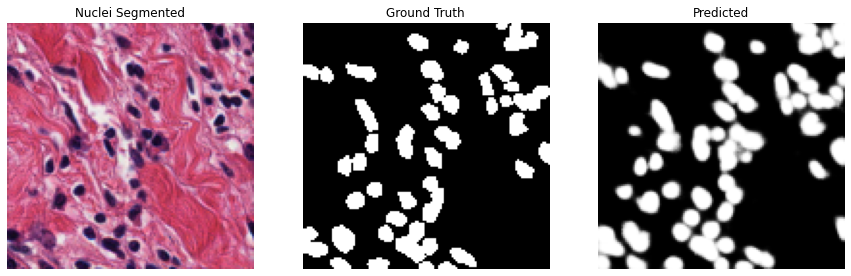

In [34]:
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(X_validaiton[5])
plt.title('Nuclei Segmented')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(y_validation[5][:,:,0])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(y_pred2[5][:,:,0])
plt.title('Predicted')
plt.show()

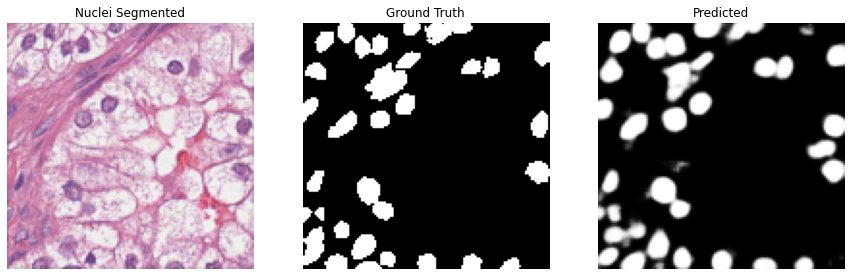

In [36]:
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(X_validaiton[100])
plt.title('Nuclei Segmented')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(y_validation[100][:,:,0])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(y_pred2[100][:,:,0])
plt.title('Predicted')
plt.show()

In [0]:
# plt.rcParams['image.cmap'] = 'gray'
# plt.figure(figsize=(15, 15))

# plt.subplot(3, 3, 1)
# plt.axis('off')
# plt.imshow(X_validaiton[0])
# plt.title('Input 1')

# plt.subplot(3, 3, 2)
# plt.axis('off')
# plt.imshow(y_validation[0][:,:,0])
# plt.title('Ground Truth 1')

# plt.subplot(3, 3, 3)
# plt.axis('off')
# plt.imshow(y_pred2[0][:,:,0])
# plt.title('Predicted 1')

# plt.subplot(3, 3, 4)
# plt.axis('off')
# plt.imshow(X_validaiton[5])
# plt.title('Input 2')

# plt.subplot(3, 3, 5)
# plt.axis('off')
# plt.imshow(y_validation[5][:,:,0])
# plt.title('Ground Truth 2')

# plt.subplot(3, 3, 6)
# plt.axis('off')
# plt.imshow(y_pred2[5][:,:,0])
# plt.title('Predicted 2')

# plt.subplot(3, 3, 7)
# plt.axis('off')
# plt.imshow(X_validaiton[100])
# plt.title('Input 3')

# plt.subplot(3, 3, 8)
# plt.axis('off')
# plt.imshow(y_validation[100][:,:,0])
# plt.title('Ground Truth 3')

# plt.subplot(3, 3, 9)
# plt.axis('off')
# plt.imshow(y_pred2[100][:,:,0])
# plt.title('Predicted 3')
# plt.show()